# KNN Synthetic Data Creation

In [1]:
# Imports
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
import csv
import warnings
import seaborn as sns
import openpyxl
from scipy import stats

# Sklearn Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

# Py File Imports
%load_ext autoreload
from supporting_functions import get_fp, loadData, saveData
from knn_correlationAnalysis import BloodRheologyAnalysis


# Get Correct Filepath
#cpu = "surface"
cpu = "man_dtop"
#cpu = "sean"
folder_fp, data_fp, figures_fp = get_fp(cpu)

# Filepaths
excel_path = os.path.join(data_fp, r"Armstrong_tESSTV_simplified.xlsx")
physio_json_path = os.path.join(data_fp, "physiological_variables.json")
rheo_json_path = os.path.join(data_fp, "rheology_variables.json")

# Call Functions
folder_fp, data_fp, figures_fp = get_fp(cpu, figuresFolder="5.synthetic/")
physiological_data, rheological_data, physDict, rheoDict, imputedRheo = loadData(data_fp)

# Get column names (excluding 'donors')
physio_cols = [col for col in physiological_data.columns if col != 'donors']
rheo_cols = [col for col in rheological_data.columns if col != 'donors']
rheo_targets_latex = [r"$\mu_0$", r"$\mu_{\infinity}$", r"$\tau_C$", r"$T_{R^1}$", r"$T_{R^2}$", r"$\mu_R$", r"$\sigma_{Y^{0}}$", r"$\tau_{\lambda}$", r"$G_R$", r"$G_C$"]

In [2]:
n_neighbors=3

# Apply KNN imputation to rheological data
rheological_values = rheological_data[rheo_cols].values
imputer = KNNImputer(n_neighbors=min(n_neighbors, len(rheological_values)//2))
imputed_rheo_data = imputer.fit_transform(rheological_values)

# Create imputed DataFrame
imputed_rheo_df = pd.DataFrame(
    imputed_rheo_data,
    columns=rheo_cols
)
imputed_rheo_df['donors'] = rheological_data['donors'].values

# Merge datasets
combined_data = pd.merge(physiological_data, imputed_rheo_df, on='donors')

# Extract features and targets
X = combined_data[physio_cols].select_dtypes(include=[np.number]).values
y = combined_data[rheo_cols].values

print(f"Final feature matrix X: {X.shape}")
print(f"Final target matrix y: {y.shape}")
print(f"Physiological features: {len(physio_cols)}")
print(f"Rheological targets: {len(rheo_cols)}")
print(f"Target names: {rheo_cols}")

Final feature matrix X: (22, 26)
Final target matrix y: (22, 10)
Physiological features: 27
Rheological targets: 10
Target names: ['mu_0 (Pa s)', 'mu_inf (Pa s)', 'tau_C (s)', 't_r1 (s)', 't_r2 (s)', 'mu_R (Pa s)', 'sigma_y0 (Pa)', 'tau_lam (s)', 'G_R (Pa)', 'G_C (Pa)']


In [3]:
# Initialize the blood rheology analysis
analysis = BloodRheologyAnalysis(X, y, rheo_cols)

print(f"Analysis initialized with:")
print(f"- Original data: {analysis.original_X.shape[0]} samples")
print(f"- Features: {analysis.original_X.shape[1]}")
print(f"- Targets: {len(analysis.target_names)}")

# Test synthetic data generation
test_n_samples = 50
X_syn, y_syn = analysis.generate_synthetic_dataset(test_n_samples)

print(f"Generated synthetic dataset:")
print(f"- Synthetic X shape: {X_syn.shape}")
print(f"- Synthetic y shape: {y_syn.shape}")
print(f"- Original samples: {len(analysis.X_scaled)}")
print(f"- Synthetic samples: {test_n_samples}")

# Test GPR performance on one target
test_target_idx = 0
test_target_name = rheo_cols[test_target_idx]

r2_score = analysis.evaluate_gpr_performance(X_syn, y_syn, target_idx=test_target_idx)

print(f"GPR Performance Test:")
print(f"- Target: {test_target_name}")
print(f"- R² Score: {r2_score:.3f}")


# Define sample sizes to test
sample_sizes = [30, 50, 75, 100]  # Adjust based on your needs
n_iterations = 3  # Number of iterations per sample size

print(f"Running power analysis...")
print(f"Sample sizes: {sample_sizes}")
print(f"Iterations per size: {n_iterations}")
print(f"Total targets: {len(rheo_cols)}")

# Run the power analysis
results = analysis.run_power_analysis(sample_sizes, n_iterations=n_iterations)

print(f"Results shape: {results.shape}")

# Display summary statistics
print("Power Analysis Results Summary:")
print("="*50)

summary = results.groupby(['n_samples'])['r2_score'].agg(['mean', 'std', 'count'])
print(summary)

print("\nBest performing sample size:")
best_n = summary['mean'].idxmax()
best_score = summary.loc[best_n, 'mean']
print(f"N = {best_n}, Average R² = {best_score:.3f}")

Analysis initialized with:
- Original data: 22 samples
- Features: 26
- Targets: 10
Generated synthetic dataset:
- Synthetic X shape: (50, 26)
- Synthetic y shape: (50, 10)
- Original samples: 22
- Synthetic samples: 50


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

GPR Performance Test:
- Target: mu_0 (Pa s)
- R² Score: 0.716
Running power analysis...
Sample sizes: [30, 50, 75, 100]
Iterations per size: 3
Total targets: 10
Running power analysis with 120 configurations...
Processing N=30...


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 8.3%


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 16.7%


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 25.0%
Processing N=50...


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 33.3%


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 41.7%


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 50.0%
Processing N=75...


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 58.3%


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 66.7%


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 75.0%
Processing N=100...


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 83.3%


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 91.7%


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

Progress: 100.0%
Results shape: (120, 4)
Power Analysis Results Summary:
               mean       std  count
n_samples                           
30        -1.656879  3.608584     30
50         0.401307  0.564474     30
75         0.087501  1.624948     30
100        0.509053  0.808435     30

Best performing sample size:
N = 100, Average R² = 0.509


/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/msmitty/Documents/TransientBloodRheo_ML/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

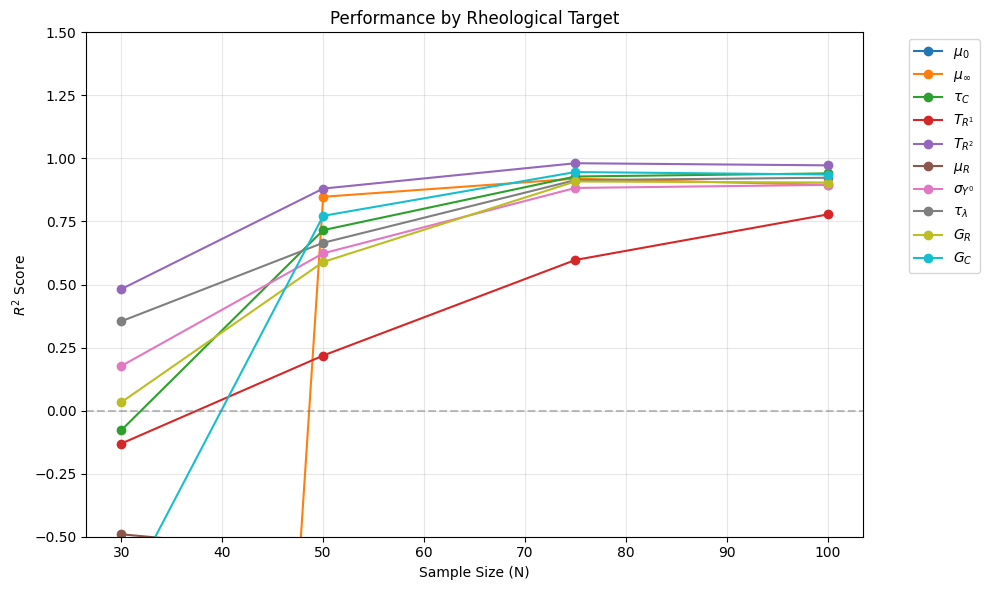

Plot Info: Y-axis limited to (-0.5, 1.5)
   Data range: -11.360 to 0.981
   27 values below -0.5 not shown
Optimal sample size analysis:
- Based on 5% improvement threshold
Performance by Rheological Target:
n_samples         30     50     75     100
target                                    
G_C (Pa)       -4.801 -0.737 -3.075 -1.047
G_R (Pa)      -11.360  0.848  0.920  0.895
mu_0 (Pa s)    -0.077  0.716  0.928  0.941
mu_R (Pa s)    -0.130  0.218  0.597  0.778
mu_inf (Pa s)   0.482  0.880  0.981  0.973
sigma_y0 (Pa)  -0.490 -0.564 -3.128 -1.107
t_r1 (s)        0.177  0.624  0.883  0.895
t_r2 (s)        0.354  0.665  0.914  0.923
tau_C (s)       0.034  0.589  0.909  0.904
tau_lam (s)    -0.757  0.772  0.946  0.936

Best performing target: mu_inf (Pa s) (R² = 0.829)
Worst performing target: G_C (Pa) (R² = -2.415)


In [4]:
# Generate plots
fp = figures_fp + 's5_012_knnSynthetic.png'
analysis.plot_results(results, fp, ylim=(-0.5, 1.5))

print(f"Optimal sample size analysis:")
print(f"- Based on 5% improvement threshold")

# Analyze performance by individual rheological target
target_summary = results.groupby(['target', 'n_samples'])['r2_score'].mean().unstack()

print("Performance by Rheological Target:")
print("="*50)
print(target_summary.round(3))

# Find best and worst performing targets
overall_target_performance = results.groupby('target')['r2_score'].mean().sort_values(ascending=False)

print(f"\nBest performing target: {overall_target_performance.index[0]} (R² = {overall_target_performance.iloc[0]:.3f})")
print(f"Worst performing target: {overall_target_performance.index[-1]} (R² = {overall_target_performance.iloc[-1]:.3f})")

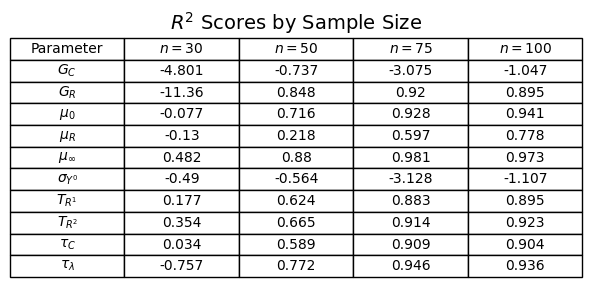

In [6]:
data = [
    [r'$G_C$', -4.801, -0.737, -3.075, -1.047],
    [r'$G_R$', -11.360, 0.848, 0.920, 0.895],
    [r'$\mu_0$', -0.077, 0.716, 0.928, 0.941],
    [r'$\mu_R$', -0.130, 0.218, 0.597, 0.778],
    [r'$\mu_{\infty}$', 0.482, 0.880, 0.981, 0.973],
    [r'$\sigma_{Y^{0}}$', -0.490, -0.564, -3.128, -1.107],
    [r'$T_{R^1}$', 0.177, 0.624, 0.883, 0.895],
    [r'$T_{R^2}$', 0.354, 0.665, 0.914, 0.923],
    [r'$\tau_C$', 0.034, 0.589, 0.909, 0.904],
    [r'$\tau_{\lambda}$', -0.757, 0.772, 0.946, 0.936]
]

# Column headers
headers = ['Parameter', r'$n=30$', r'$n=50$', r'$n=75$', r'$n=100$']

# Create figure
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')

# Create table
table = ax.table(cellText=data,
                colLabels=headers,
                cellLoc='center',
                loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.title(r'$R^2$ Scores by Sample Size', fontsize=14, pad=20)
plt.tight_layout()
fp = figures_fp + 's5_013_knnSynthetic_table.png'
plt.savefig(fp, dpi=300, bbox_inches='tight')
plt.show()